# Introduction

Three groups: microsatellite instability high (MSI-H), microsatellite instability low (MSI-L) and microsatellite stable (MSS).

Two sets of measurements: 7_marker, 5_marker. The original report consider one sample as MSI if both indicate positive.

In [1]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# mpl.rcParams['figure.dpi'] = 600

In [2]:
import sys
sys.path.append("..")
import sensei

In [3]:
df = pd.read_excel("41591_2016_BFnm4191_MOESM27_ESM.xlsx", index=1)
df

,Sample Name,Average difference in microsatellite alleles relative to paired normal,Number Unstable Loci,Number Loci Called,Proportion Unstable Loci,Stability at chr8:7679723-7679741,MOSAIC classification,Tumor Type,MSI-PCR Result,In Training Set?
0,TCGA-GV-A6ZA,-0.000393,510,144859,0.003521,stable,MSS,BLCA,NaN,no
1,TCGA-H4-A2HO,0.001674,1203,244912,0.004912,stable,MSS,BLCA,NaN,no
2,TCGA-H4-A2HQ,0.000091,915,230733,0.003966,stable,MSS,BLCA,NaN,no
3,TCGA-HQ-A2OE,0.000061,526,165003,0.003188,stable,MSS,BLCA,NaN,no
4,TCGA-HQ-A2OF,0.000605,407,128967,0.003156,stable,MSS,BLCA,NaN,no
...,...,...,...,...,...,...,...,...,...,...
5925,TCGA-QS-A8F1,-0.000477,1316,226304,0.005815,stable,MSS,UCEC,ND,no
5926,TCGA-SJ-A6ZI,0.008849,3363,298901,0.011251,unstable,MSI-H,UCEC,ND,no
5927,TCGA-SJ-A6ZJ,0.002213,1610,239070,0.006734,stable,MSS,UCEC,ND,no
5928,TCGA-SL-A6J9,-0.000376,1023,194265,0.005266,stable,MSS,UCEC,ND,no


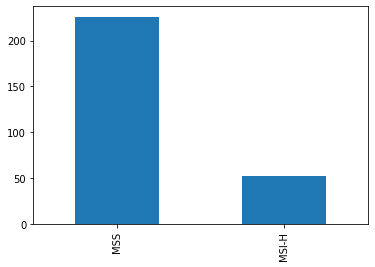

In [4]:
df[df['Tumor Type'] == 'STAD']['MOSAIC classification'].value_counts().plot(kind="bar")

In [5]:
f = lambda x: x[0:3]
msi_mask = (df['MOSAIC classification'] == 'MSI-H') & (df['Tumor Type'] == 'STAD')
mss_mask = (df['MOSAIC classification'] == 'MSS') & (df['Tumor Type'] == 'STAD')

msi_patient_id = df['Sample Name'][msi_mask].to_frame()
mss_patient_id = df['Sample Name'][mss_mask].to_frame()

msi_patient_id['microsatellite'] = 'MSI-H'
mss_patient_id['microsatellite'] = 'MSS'

microsatellite_label_df = msi_patient_id.append(mss_patient_id)

In [6]:
data = pd.read_csv("TCGA.Kallisto.fullIDs.cibersort.relative.tsv", sep="\t")
data["SampleID"] = data["SampleID"].apply(lambda x: x.replace('.', '-'))
data["PatientID"] = data["SampleID"].apply(lambda x: '-'.join(x.split('-')[0:3]))

In [7]:
merged = data.merge(microsatellite_label_df, left_on="PatientID", right_on='Sample Name')

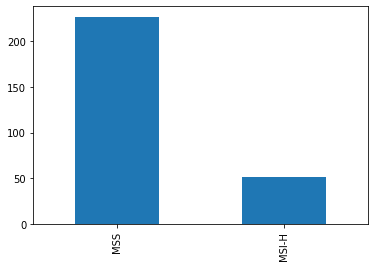

In [8]:
merged.microsatellite.value_counts().plot(kind="bar")

In [9]:
cell_types = ['B.cells.naive', 'B.cells.memory', 'Plasma.cells', 'T.cells.CD8',
       'T.cells.CD4.naive', 'T.cells.CD4.memory.resting',
       'T.cells.CD4.memory.activated', 'T.cells.follicular.helper',
       'T.cells.regulatory..Tregs.', 'T.cells.gamma.delta', 'NK.cells.resting',
       'NK.cells.activated', 'Monocytes', 'Macrophages.M0', 'Macrophages.M1',
       'Macrophages.M2', 'Dendritic.cells.resting',
       'Dendritic.cells.activated', 'Mast.cells.resting',
       'Mast.cells.activated', 'Eosinophils', 'Neutrophils']

#merged['Leukocytes.all'] = merged[cell_types].sum(1)

merged['T.cells.all'] = merged[['T.cells.CD8',
                                    'T.cells.CD4.naive',
                                    'T.cells.CD4.memory.resting',
                                    'T.cells.CD4.memory.activated',
                                    'T.cells.follicular.helper',
                                    'T.cells.regulatory..Tregs.',
                                    'T.cells.gamma.delta']].sum(1)

merged['B.cells.all'] = merged[['B.cells.naive', 'B.cells.memory', 'Plasma.cells']].sum(1)

merged['Nk.cells.all'] = merged[['NK.cells.resting', 'NK.cells.activated']].sum(1)

merged['Macrophages.all'] = merged[['Macrophages.M0', 'Macrophages.M1', 'Macrophages.M2']].sum(1)

merged['Dendritic.cells.all'] = merged[['Dendritic.cells.resting', 'Dendritic.cells.activated']].sum(1)

merged['Mast.cells.all'] = merged[['Mast.cells.resting', 'Mast.cells.activated']].sum(1)



augmented_cell_types = cell_types + ['T.cells.all', 'B.cells.all', 'Nk.cells.all', 'Macrophages.all', 
                                     'Dendritic.cells.all', 'Mast.cells.all']

merged

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,RMSE,PatientID,Sample Name,microsatellite,T.cells.all,B.cells.all,Nk.cells.all,Macrophages.all,Dendritic.cells.all,Mast.cells.all
0,TCGA-BR-4366-01A-01R-1157-13,STAD,0.032055,0.000000,0.027246,0.040256,0.0,0.147815,0.000000,0.028220,...,1.069646,TCGA-BR-4366,TCGA-BR-4366,MSS,0.216291,0.059301,0.010803,0.612398,0.034294,0.033081
1,TCGA-BR-4191-01A-02R-1131-13,STAD,0.024851,0.010477,0.000000,0.065190,0.0,0.191097,0.017984,0.032975,...,1.063747,TCGA-BR-4191,TCGA-BR-4191,MSS,0.320662,0.035328,0.095126,0.345343,0.055613,0.091286
2,TCGA-BR-4201-01A-01R-1131-13,STAD,0.023210,0.009460,0.004675,0.051023,0.0,0.139001,0.073866,0.037223,...,1.067880,TCGA-BR-4201,TCGA-BR-4201,MSI-H,0.301114,0.037345,0.073367,0.255547,0.020096,0.192896
3,TCGA-BR-4253-01A-01R-1131-13,STAD,0.017905,0.000000,0.006844,0.201760,0.0,0.055790,0.156011,0.063808,...,1.064595,TCGA-BR-4253,TCGA-BR-4253,MSS,0.482885,0.024749,0.074619,0.296151,0.031128,0.077579
4,TCGA-BR-4279-01A-01R-1131-13,STAD,0.072362,0.000000,0.071028,0.069597,0.0,0.122167,0.021084,0.013978,...,0.999862,TCGA-BR-4279,TCGA-BR-4279,MSS,0.226826,0.143389,0.039030,0.317939,0.039721,0.123131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,TCGA-VQ-A94O-01A-11R-A414-31,STAD,0.071646,0.000000,0.031929,0.062492,0.0,0.264634,0.032723,0.092050,...,1.042667,TCGA-VQ-A94O,TCGA-VQ-A94O,MSS,0.517972,0.103575,0.070056,0.167319,0.008671,0.122024
274,TCGA-VQ-A94R-01A-11R-A414-31,STAD,0.021858,0.005412,0.029638,0.119135,0.0,0.201150,0.000000,0.064530,...,1.062122,TCGA-VQ-A94R,TCGA-VQ-A94R,MSS,0.458901,0.056908,0.019353,0.404512,0.000000,0.037004
275,TCGA-VQ-AA6D-01A-11R-A414-31,STAD,0.000000,0.000000,0.045217,0.030275,0.0,0.288500,0.000000,0.096045,...,1.080485,TCGA-VQ-AA6D,TCGA-VQ-AA6D,MSI-H,0.429092,0.045217,0.027922,0.362261,0.019650,0.100884
276,TCGA-KB-A93G-01A-11R-A39E-31,STAD,0.027300,0.000000,0.000000,0.006516,0.0,0.149925,0.000000,0.002987,...,1.054709,TCGA-KB-A93G,TCGA-KB-A93G,MSS,0.159428,0.027300,0.050503,0.316725,0.022506,0.345506


In [10]:
mss = merged[merged.microsatellite == 'MSS'][augmented_cell_types]
msi = merged[merged.microsatellite == 'MSI-H'][augmented_cell_types]

In [11]:
mss

,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,T.cells.regulatory..Tregs.,T.cells.gamma.delta,...,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,T.cells.all,B.cells.all,Nk.cells.all,Macrophages.all,Dendritic.cells.all,Mast.cells.all
0,0.032055,0.000000,0.027246,0.040256,0.0,0.147815,0.000000,0.028220,0.000000,0.0,...,0.000000,0.033081,0.000000,0.004576,0.216291,0.059301,0.010803,0.612398,0.034294,0.033081
1,0.024851,0.010477,0.000000,0.065190,0.0,0.191097,0.017984,0.032975,0.013416,0.0,...,0.000000,0.091286,0.026671,0.000000,0.320662,0.035328,0.095126,0.345343,0.055613,0.091286
3,0.017905,0.000000,0.006844,0.201760,0.0,0.055790,0.156011,0.063808,0.005516,0.0,...,0.000000,0.077579,0.000000,0.000000,0.482885,0.024749,0.074619,0.296151,0.031128,0.077579
4,0.072362,0.000000,0.071028,0.069597,0.0,0.122167,0.021084,0.013978,0.000000,0.0,...,0.000000,0.123131,0.001558,0.028098,0.226826,0.143389,0.039030,0.317939,0.039721,0.123131
5,0.042910,0.000000,0.011404,0.136809,0.0,0.158403,0.012718,0.000000,0.011641,0.0,...,0.000000,0.039208,0.127283,0.021332,0.319571,0.054314,0.016372,0.281320,0.003359,0.039208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,0.106521,0.000000,0.060138,0.014565,0.0,0.212024,0.000000,0.106941,0.000000,0.0,...,0.012525,0.028037,0.000000,0.000000,0.333530,0.166659,0.044323,0.396391,0.000000,0.040562
273,0.071646,0.000000,0.031929,0.062492,0.0,0.264634,0.032723,0.092050,0.066073,0.0,...,0.000000,0.122024,0.000000,0.000000,0.517972,0.103575,0.070056,0.167319,0.008671,0.122024
274,0.021858,0.005412,0.029638,0.119135,0.0,0.201150,0.000000,0.064530,0.074086,0.0,...,0.037004,0.000000,0.000000,0.000000,0.458901,0.056908,0.019353,0.404512,0.000000,0.037004
276,0.027300,0.000000,0.000000,0.006516,0.0,0.149925,0.000000,0.002987,0.000000,0.0,...,0.000000,0.345506,0.000000,0.054744,0.159428,0.027300,0.050503,0.316725,0.022506,0.345506


# Results

## MSS

In [12]:
a = 0.05

sanitize = lambda x: 0.0 if x < 0 else 1.0 if x > 1 else x

res_mss = pd.DataFrame(index = cell_types, columns = ['mean', 'mean lower', 'mean upper', 'sd', 'sd lower', 'sd upper'])

n = mss.shape[0];

# Mean
res_mss['mean'] = mss.mean(axis=0)

res_mss['sd'] = mss.std(ddof=1, axis=0)
        
# Mean CI
err = scipy.stats.t.ppf(1 - a / 2, n - 1) * res_mss['sd'] / np.sqrt(n)
res_mss['mean lower'] = (res_mss['mean'] - err).apply(sanitize)
res_mss['mean upper'] = (res_mss['mean'] + err).apply(sanitize)
        
# Standard deviation CI
res_mss['sd lower'] = np.sqrt((n - 1) * res_mss['sd'] ** 2 / scipy.stats.chi2.ppf(1 - a / 2, n - 1))
res_mss['sd upper'] = np.sqrt((n - 1) * res_mss['sd'] ** 2 / scipy.stats.chi2.ppf(a / 2, n - 1))

res_mss

,mean,mean lower,mean upper,sd,sd lower,sd upper
B.cells.naive,0.068216,0.059161,0.077271,0.069233,0.063396,0.076263
B.cells.memory,0.035908,0.027786,0.044030,0.062102,0.056867,0.068408
Plasma.cells,0.043567,0.036683,0.050451,0.052633,0.048196,0.057977
T.cells.CD8,0.117301,0.107900,0.126702,0.071880,0.065820,0.079179
T.cells.CD4.naive,0.000420,0.000000,0.001135,0.005461,0.005001,0.006015
T.cells.CD4.memory.resting,0.160961,0.150412,0.171510,0.080655,0.073855,0.088844
T.cells.CD4.memory.activated,0.010443,0.007110,0.013776,0.025487,0.023338,0.028075
T.cells.follicular.helper,0.063229,0.057482,0.068977,0.043945,0.040240,0.048407
T.cells.regulatory..Tregs.,0.042226,0.037927,0.046526,0.032875,0.030103,0.036213
T.cells.gamma.delta,0.000246,0.000000,0.000644,0.003038,0.002782,0.003346


## MSI

In [13]:
a = 0.05

sanitize = lambda x: 0.0 if x < 0 else 1.0 if x > 1 else x

res_msi = pd.DataFrame(index = cell_types, columns = ['mean', 'mean lower', 'mean upper', 'sd', 'sd lower', 'sd upper'])

n = msi.shape[0];

# Mean
res_msi['mean'] = msi.mean(axis=0)

res_msi['sd'] = msi.std(ddof=1, axis=0)
        
# Mean CI
err = scipy.stats.t.ppf(1 - a / 2, n - 1) * res_msi['sd'] / np.sqrt(n)
res_msi['mean lower'] = (res_msi['mean'] - err).apply(sanitize)
res_msi['mean upper'] = (res_msi['mean'] + err).apply(sanitize)
        
# Standard deviation CI
res_msi['sd lower'] = np.sqrt((n - 1) * res_msi['sd'] ** 2 / scipy.stats.chi2.ppf(1 - a / 2, n - 1))
res_msi['sd upper'] = np.sqrt((n - 1) * res_msi['sd'] ** 2 / scipy.stats.chi2.ppf(a / 2, n - 1))

res_msi

,mean,mean lower,mean upper,sd,sd lower,sd upper
B.cells.naive,0.046578,0.032953,0.060203,0.048444,0.040534,0.060220
B.cells.memory,0.018551,0.008894,0.028208,0.034337,0.028730,0.042683
Plasma.cells,0.037317,0.023172,0.051462,0.050292,0.042080,0.062517
T.cells.CD8,0.138500,0.118453,0.158548,0.071278,0.059639,0.088604
T.cells.CD4.naive,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
T.cells.CD4.memory.resting,0.145727,0.124826,0.166629,0.074316,0.062180,0.092380
T.cells.CD4.memory.activated,0.037119,0.024447,0.049791,0.045055,0.037698,0.056007
T.cells.follicular.helper,0.074318,0.063063,0.085573,0.040017,0.033483,0.049745
T.cells.regulatory..Tregs.,0.038402,0.029426,0.047378,0.031914,0.026703,0.039671
T.cells.gamma.delta,0.000446,0.000000,0.001092,0.002297,0.001922,0.002855


## Figures

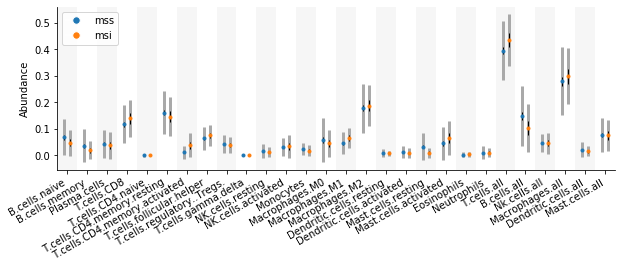

In [14]:
x_map = {v: i for i, v in enumerate(augmented_cell_types)}

offset_map = {
 'mss': -0.15,
 'msi': 0.15}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

color_map = {'mss': colors[0],
 'msi': colors[1]}

fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(1, 1, 1)

n = mss.shape[0];
mean = mss.mean(axis=0)
sd = mss.std(ddof=1, axis=0)
err = scipy.stats.t.ppf(1 - a / 2, n - 1) * sd / np.sqrt(n)

x = [v + offset_map['mss'] for v in x_map.values()]
    
ax.errorbar(x, mean, yerr=sd, fmt='.', color = color_map['mss'], ecolor = 'darkgray', elinewidth=3.0)
ax.errorbar(x, mean, yerr=err, fmt="None", color = color_map['mss'], ecolor = 'black', elinewidth=1.0)

n = msi.shape[0];
mean = msi.mean(axis=0)
sd = msi.std(ddof=1, axis=0)
err = scipy.stats.t.ppf(1 - a / 2, n - 1) * sd / np.sqrt(n)

x = [v + offset_map['msi'] for v in x_map.values()]
    
ax.errorbar(x, mean, yerr=sd, fmt='.', color = color_map['msi'], ecolor = 'darkgray', elinewidth=3.0)
ax.errorbar(x, mean, yerr=err, fmt="None", color = color_map['msi'], ecolor = 'black', elinewidth=1.0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

current_ylim = ax.get_ylim()
for v in x_map.values():
    if v % 2 == 0:
        ax.fill_between([v - 0.5, v + 0.5], current_ylim[0], current_ylim[1], facecolor='lightgray', alpha=0.2)

ax.set_ylim(current_ylim)
ax.set_xticks(list(x_map.values()))
ax.tick_params(axis='x', which = 'both', labelbottom=None)
ax.set_ylabel('Abundance')
ax.set_xlim(-0.5, len(x_map) - 0.5)
    
# Ticks
ax.tick_params(axis='x', which = 'both', labelbottom=True)
ax.set_xticks(list(x_map.values()))
ax.set_xticklabels(list(x_map.keys()), rotation=30, ha='right')

legend_elements = [mpl.lines.Line2D([0], [0], marker='.', color='w', markerfacecolor=color_map[i], label=i, markersize=15) 
                   for i in color_map]

ax.legend(handles=legend_elements, loc='upper left')

In [15]:
len(cell_types)

22

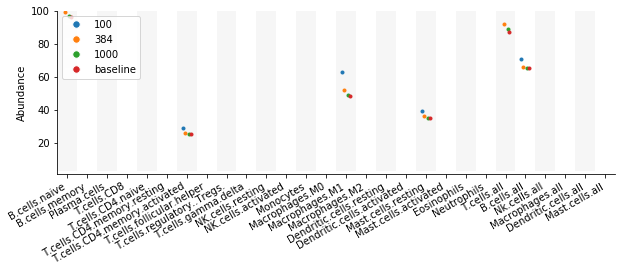

In [16]:
x_map = {v: i for i, v in enumerate(augmented_cell_types)}

offset_map = {
 100: -0.2,
 384: -0.1,
 1000: 0.1,
 'baseline': 0.2}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

color_map = {
 100: colors[0],
 384: colors[1],
 1000: colors[2],
 'baseline': colors[3]}

mem = {100: None,
      384: None,
      1000: None,
      'baseline': None}

fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(1, 1, 1)

mss_n = mss.shape[0];
mss_mean = mss.mean(axis=0)
mss_sd = mss.std(ddof=1, axis=0)
mss_err = scipy.stats.t.ppf(1 - a / 2, mss_n - 1) * mss_sd / np.sqrt(mss_n)

msi_n = msi.shape[0];
msi_mean = msi.mean(axis=0)
msi_sd = msi.std(ddof=1, axis=0)
msi_err = scipy.stats.t.ppf(1 - a / 2, msi_n - 1) * msi_sd / np.sqrt(msi_n)

for cell_number in [100, 384, 1000]:
    x = [v + offset_map[cell_number] for v in x_map.values()]
    y = [sensei.optimize.find_minimum_M(500, cell_number, [m0, m1], [s0, s1], beta=0.2, design='unpaired') for m0, m1, s0, s1 in zip(mss_mean, msi_mean, mss_sd, msi_sd)]    
    ax.errorbar(x, y, yerr=0, fmt='.', color = color_map[cell_number], ecolor = 'darkgray', elinewidth=3.0)
    mem[cell_number] = y
    
x = [v + offset_map['baseline'] for v in x_map.values()]
y = [sensei.optimize.find_minimum_M(500, cell_number, [m0, m1], [s0, s1], beta=0.2, design='unpaired-baseline') for m0, m1, s0, s1 in zip(mss_mean, msi_mean, mss_sd, msi_sd)]    
ax.errorbar(x, y, yerr=0, fmt='.', color = color_map['baseline'], ecolor = 'darkgray', elinewidth=3.0)
mem['baseline'] = y

import pickle as pkl
with open("msi-mss-stad.pkl", 'wb') as f:
    pkl.dump(mem, f)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

current_ylim = ax.get_ylim()
for v in x_map.values():
    if v % 2 == 0:
        ax.fill_between([v - 0.5, v + 0.5], current_ylim[0], current_ylim[1], facecolor='lightgray', alpha=0.2)

ax.set_ylim([1, 100])
ax.set_xticks(list(x_map.values()))
ax.tick_params(axis='x', which = 'both', labelbottom=None)
ax.set_ylabel('Abundance')
ax.set_xlim(-0.5, len(x_map) - 0.5)
    
# Ticks
ax.tick_params(axis='x', which = 'both', labelbottom=True)
ax.set_xticks(list(x_map.values()))
ax.set_xticklabels(list(x_map.keys()), rotation=30, ha='right')

legend_elements = [mpl.lines.Line2D([0], [0], marker='.', color='w', markerfacecolor=color_map[i], label=i, markersize=15) 
                   for i in color_map]

ax.legend(handles=legend_elements, loc='upper left')

In [17]:
augmented_cell_types

['B.cells.naive',
 'B.cells.memory',
 'Plasma.cells',
 'T.cells.CD8',
 'T.cells.CD4.naive',
 'T.cells.CD4.memory.resting',
 'T.cells.CD4.memory.activated',
 'T.cells.follicular.helper',
 'T.cells.regulatory..Tregs.',
 'T.cells.gamma.delta',
 'NK.cells.resting',
 'NK.cells.activated',
 'Monocytes',
 'Macrophages.M0',
 'Macrophages.M1',
 'Macrophages.M2',
 'Dendritic.cells.resting',
 'Dendritic.cells.activated',
 'Mast.cells.resting',
 'Mast.cells.activated',
 'Eosinophils',
 'Neutrophils',
 'T.cells.all',
 'B.cells.all',
 'Nk.cells.all',
 'Macrophages.all',
 'Dendritic.cells.all',
 'Mast.cells.all']